# Worksheet 19

Name: Ryan Chung 
UID: U33101958 

### Topics

- Linear Model Evaluation

## Linear Model Evaluation

Notice that R^2 only increases with the number of explanatory variables used. Hence the need for an adjusted R^2 that penalizes for insignificant explanatory variables.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

SAMPLE_SIZE = 100
beta = [1, 5]
X = -10.0 + 10.0 * np.random.random(SAMPLE_SIZE)
Y = beta[0] + beta[1] * X + np.random.randn(SAMPLE_SIZE)

for i in range(1, 15):
    X_transform = PolynomialFeatures(degree=i, include_bias=False).fit_transform(X.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_transform, Y)
    print(model.score(X_transform, Y))

0.9955376402266154
0.9955584459257738
0.9955591631195024
0.9956809747517399
0.995694693194866
0.9956975277840221
0.9958549930845247
0.995864478112323
0.9958655967685489
0.9958670521320895
0.9958927779625605
0.9958933628230725
0.9958833917858194
0.9958766777127396


a) Hypothesis Testing Sandbox (follow along in class) [Notes](https://medium.com/@gallettilance/hypothesis-testing-almost-everything-you-need-to-know-ce812ded50b)

0.31249999999999983
[1, 0, 1, 1, 1]
0.15625


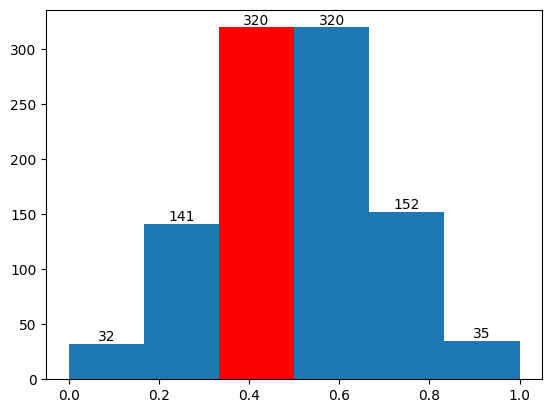

In [2]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

flips = [1, 0, 0, 1, 0]

def num_successes(flips):
    return sum(flips)

print(binom.pmf(num_successes(flips), len(flips), 1/2))

SAMPLE_SIZE = 5
flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
print(flips)
print(binom.pmf(num_successes(flips), SAMPLE_SIZE, 1/2))

p_est = []

for _ in range(1000):
    flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
    p_est.append(sum(flips) / SAMPLE_SIZE)

fig, ax = plt.subplots()
_, bins, patches = ax.hist(p_est, bins=SAMPLE_SIZE + 1)
p = np.digitize([2/5], bins)
patches[p[0]-1].set_facecolor('r')
ax.bar_label(patches)
plt.show()

b) Plot a data set and fitted line through the point when there is no relationship between X and y.

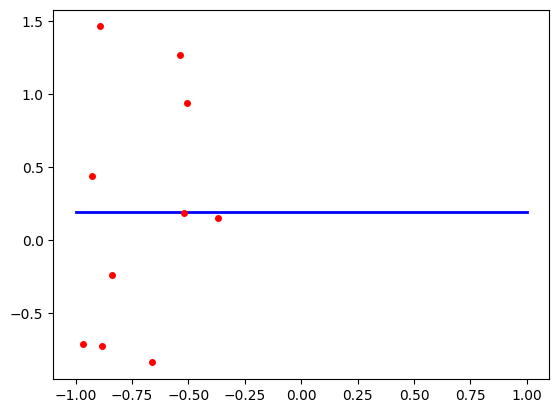

In [3]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_SIZE = 10

xlin = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
y = 0.5 + np.random.randn(SAMPLE_SIZE)

intercept = np.ones(np.shape(xlin)[0])
X = np.array([intercept, xlin]).T
beta = [np.mean(y), 0]

xplot = np.linspace(-1,1,20)
yestplot = beta[0] + beta[1] * xplot
plt.plot(xplot, yestplot,'b-',lw=2)
plt.plot(xlin, y,'ro',markersize=4)
plt.show()

c) Using the above code, plot a histogram of the parameter estimates for the slope after generating `1000` independent datasets. Comment on what the plot means. Increase the sample size to see what happens to the plot. Explain.

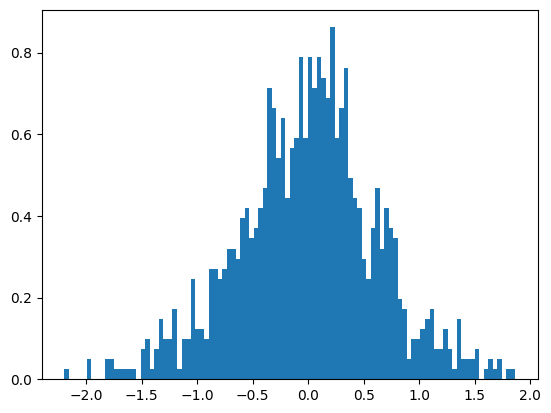

In [5]:
beta_hist = []
for _ in range(1000):
    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.5 + np.random.randn(SAMPLE_SIZE)
    X = xlin.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    beta_hist.append(model.coef_[0])

fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
plt.savefig("deez.png")
plt.show()

The graph shows the distribution of the slope estimate from a series of linear regressions. If we increased the sample size, in each regression, the distribution would likely become narrower, concentrating more around the true parameter value because of reduced variance.

d) We know that:

$$\hat\beta-\beta \sim \mathcal{N}(0,\sigma^2 (X^TX)^{-1})$$

thus for each component $k$ of $\hat\beta$ (here there are only two - one slope and one intercept)

$$\hat\beta_k -\beta_k \sim \mathcal{N}(0, \sigma^2 S_{kk})$$

where $S_{kk}$ is the $k^\text{th}$ diagonal element of $(X^TX)^{-1}$. Thus, we know that 

$$z_k = \frac{\hat\beta_k -\beta_k}{\sqrt{\sigma^2 S_{kk}}} \sim \mathcal{N}(0,1)$$

Verify that this is the case through a simulation and compare it to the standard normal pdf by plotting it on top of the histogram.

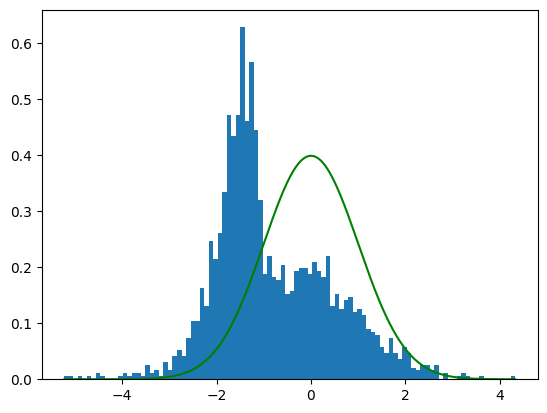

In [6]:
from scipy.stats import norm

beta_hist = []
for _ in range(1000):
    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.5 + np.random.randn(SAMPLE_SIZE)
    X = np.c_[np.ones((SAMPLE_SIZE, 1)), xlin] 
    model = LinearRegression().fit(X, y)
    residuals = y - model.predict(X)
    sigma_squared = np.var(residuals, ddof=2)
    S_kk = np.linalg.inv(X.T @ X).diagonal() 
    beta_hist.extend((model.coef_ - [0.5, 0]) / np.sqrt(sigma_squared * S_kk))

xs = np.linspace(min(beta_hist), max(beta_hist), 1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
ax.plot(xs, norm.pdf(xs), color='green')  
plt.show()

e) Above we normalized $\hat\beta$ by subtracting the mean and dividing by the standard deviation. While we know that the estimate of beta is an unbiased estimator, we don't know the standard deviation. So in practice when doing a hypothesis test where we want to assume that $\beta = 0$, we can simply use $\hat\beta$ in the numerator. However we don't know the standard deviation and need to use an unbiased estimate of the standard deviation instead. This estimate is the standard error `s`

$$s = \sqrt{\frac{RSS}{n - p}}$$

where p is the number of parameters beta (here there are 2 - one slope and one intercept). This normalized $\hat\beta$ can be shown to follow a t-distribution with `n-p` degrees of freedom. Verify this is the case with a simulation.

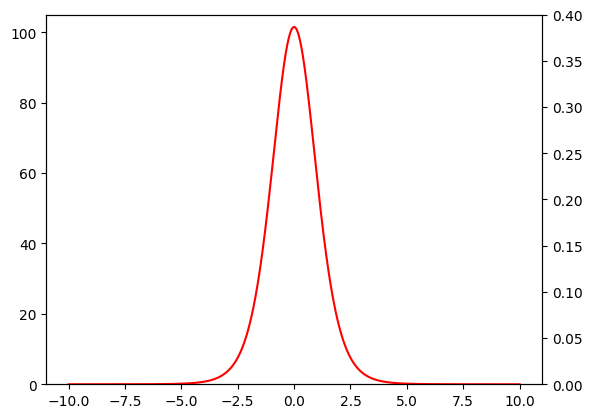

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t

def standard_error(y_true, y_pred):
    n = len(y_true)
    p = 2 
    rss = np.sum((y_true - y_pred) ** 2)
    return np.sqrt(rss / (n - p))

beta_hist = []

for _ in range(1000):
    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.5 + np.random.randn(SAMPLE_SIZE)
    X = np.c_[np.ones((SAMPLE_SIZE, 1)), xlin]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    se = standard_error(y, y_pred)
    beta_hist.append(model.coef_[0] / se)

fig, ax1 = plt.subplots()
ax1.hist(beta_hist, bins=100, density=True, color='gray', alpha=0.5)
ax2 = ax1.twinx()
xs = np.linspace(-10, 10, 1000)
ax2.plot(xs, t.pdf(xs, df=SAMPLE_SIZE - 2), color='red')
ax2.set_ylim(0, 0.4)
plt.show()


f) You are given the following dataset:

[0.50155603 1.19902827]


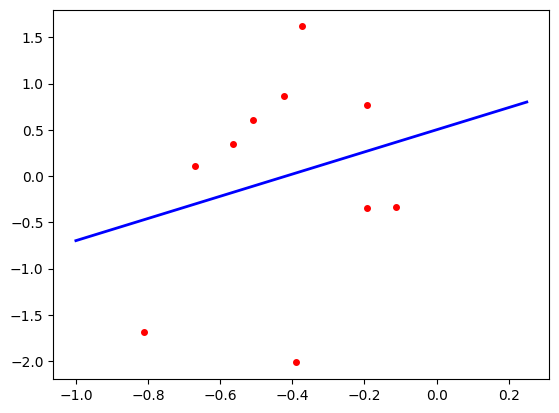

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, -1.68912015, -2.01463592, 1.61798563, 0.60557414])

intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

print(beta_hat)

xplot = np.linspace(-1,.25,20)
yestplot = beta_hat[0] + beta_hat[1] * xplot
plt.plot(xplot, yestplot,'b-',lw=2)
plt.plot(x, y,'ro',markersize=4)
plt.show()


what is the probability of observing a dataset at least as extreme as the above assuming $\beta = 0$ ?

In [13]:
from scipy import stats

n = len(x)  
p = 2  

intercept = np.ones(n)
X = np.vstack((intercept, x)).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

y_hat = X @ beta_hat
residuals = y - y_hat
RSS = np.sum(residuals ** 2)

var_x = np.var(x, ddof=1)
SE_beta_hat = np.sqrt(RSS / ((n - p) * var_x))

t_statistic = beta_hat[1] / SE_beta_hat
p_value = stats.t.sf(np.abs(t_statistic), n - p) * 2 

print(p_value)

0.8253009685222907
